<a href="https://colab.research.google.com/github/LennyHenrydoesGitHub/OSINT/blob/main/model/model_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import torch.nn as nn
from google.colab import files, drive
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare input data for RNN


In [2]:
df = pd.read_csv('/content/drive/My Drive/Data_sci/df.csv')
matrix = pd.read_csv('/content/drive/My Drive/Data_sci/matrix_names.csv')

categorical_cols = ['Recipient', 'Supplier', 'Weapon designation']
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[categorical_cols])

numeric_cols = ['Year of order', 'Number ordered', 'SIPRI TIV per unit', 'SIPRI TIV for total order', 'SIPRI TIV of delivered weapons']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])

def extract_arms_trade_data(recipient, target_year, ys):
    data = df[(df['Recipient'] == recipient) & (df['Year of order'] >= target_year - ys[1]) & (df['Year of order'] < target_year - ys[0])]
    if data.empty:
      return None, None

    encoded_data = encoder.transform(data[categorical_cols])
    scaled_data = scaler.transform(data[numeric_cols])

    input_data = np.concatenate((encoded_data.toarray(), scaled_data), axis=1)

    year_rows = matrix[matrix['Year'] == target_year]
    if year_rows[recipient].sum() == 0:
        target = 0
    else:
        target = 1

    return input_data, target

def generate_random_samples(actor_matrix, n, ratio, ys):
    random_samples = []

    one_indices = actor_matrix[actor_matrix == 1].stack().index.tolist()
    zero_indices = actor_matrix[actor_matrix == 0].stack().index.tolist()

    sampled_one_indices = random.sample(one_indices, int(n * ratio))
    sampled_zero_indices = random.sample(zero_indices, n - int(n * ratio))
    sampled_indices = sampled_one_indices + sampled_zero_indices
    random.shuffle(sampled_indices)

    for idx, country in sampled_indices:
        year = actor_matrix.loc[idx, 'Year']
        input_data, target = extract_arms_trade_data(country, year, ys)

        if input_data is not None and target is not None:
            input_data = torch.tensor(input_data, dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)

            if not torch.isnan(input_data).any() and not torch.isnan(target):
                X_rnn = input_data
                y_rnn = target

                random_samples.append((X_rnn, y_rnn, country, year))

    return random_samples


### Define the RNN model

In [3]:
input_size = 4404
output_size = 1
hidden_size = 256
num_layers = 3
dropout = 0.4

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=dropout):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

model = RNNModel(input_size, hidden_size, output_size, num_layers, dropout)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


### Running 10 iterations of the model

In [24]:
num_epochs = 20
results = []
ratios = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05]
ys_pairs = [[1,5]]
for ratio in ratios:
    for ys_pair in ys_pairs:
        model = RNNModel(input_size, hidden_size, output_size, num_layers, dropout)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        model.to(device)
        n = 1550
        random_samples = generate_random_samples(matrix, n, ratio, ys_pair)

        for i in range(len(random_samples)):
            X_rnn, y_rnn, country, year = random_samples[i]
            random_samples[i] = (X_rnn.to(device), y_rnn.to(device), country, year)

        train_size = int(0.8 * len(random_samples))
        val_size = int(0.1 * len(random_samples))
        test_size = len(random_samples) - train_size - val_size

        train_set, val_set, test_set = random_samples[:train_size], random_samples[train_size:train_size + val_size], random_samples[-test_size:]

        val_accuracies = []
        test_accuracies = []
        true_labels_list = []
        predicted_labels_list = []
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for X_rnn, y_rnn, _, _ in train_set:
                optimizer.zero_grad()
                X_rnn = X_rnn.unsqueeze(0)
                outputs = model(X_rnn)
                predictions = (outputs.squeeze() > 0.5).float()
                loss = criterion(outputs.squeeze(), y_rnn)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                correct_predictions += (predictions == y_rnn).sum().item()
                total_samples += 1

            model.eval()
            val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():
                for X_val, y_val, _, _ in val_set:
                    X_val = X_val.unsqueeze(0)
                    outputs_val = model(X_val)
                    predictions_val = (outputs_val.squeeze() > 0.5).float()
                    val_loss += criterion(outputs_val.squeeze(), y_val).item()
                    val_correct_predictions += (predictions_val == y_val).sum().item()
                    val_total_samples += 1

            epoch_loss = running_loss / len(train_set)
            val_accuracy = val_correct_predictions / val_total_samples
            scheduler.step(val_accuracy)

            val_accuracies.append(val_accuracy)

        model.eval()
        test_correct_predictions = 0
        test_total_samples = 0
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for X_test, y_test, _, _ in test_set:
                X_test = X_test.unsqueeze(0)
                outputs_test = model(X_test)
                predictions_test = (outputs_test.squeeze() > 0.5).float()
                test_correct_predictions += (predictions_test == y_test).sum().item()
                test_total_samples += 1
                true_labels.append(y_test.item())
                predicted_labels.append(predictions_test.item())

                true_positives += ((predictions_test == 1) & (y_test == 1)).sum().item()
                false_positives += ((predictions_test == 1) & (y_test == 0)).sum().item()
                true_negatives += ((predictions_test == 0) & (y_test == 0)).sum().item()
                false_negatives += ((predictions_test == 0) & (y_test == 1)).sum().item()


        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1 = 2 * (precision * recall) / (precision + recall)

        test_accuracy = test_correct_predictions / test_total_samples
        test_accuracies.append(test_accuracy)
        true_labels_list.append(true_labels)
        predicted_labels_list.append(predicted_labels)

        results.append({
            'val_accuracies': val_accuracies,
            'test_accuracy': test_accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_labels': true_labels_list,
            'predicted_labels': predicted_labels_list
        })
        print(f'YS pair: {ys_pair}, Ratio: {ratio}, Test Accuracy: {test_accuracy:.5f}, Validation Accuracies: {val_accuracies}')




YS pair: [1, 5], Ratio: 0.5, Test Accuracy: 0.73600, Validation Accuracies: [0.6910569105691057, 0.6910569105691057, 0.7154471544715447, 0.7317073170731707, 0.7479674796747967, 0.7560975609756098, 0.7398373983739838, 0.7560975609756098, 0.7642276422764228, 0.7642276422764228, 0.7723577235772358, 0.7804878048780488, 0.7642276422764228, 0.7317073170731707, 0.8048780487804879, 0.7967479674796748, 0.7723577235772358, 0.7560975609756098, 0.7317073170731707, 0.7642276422764228]
YS pair: [1, 5], Ratio: 0.45, Test Accuracy: 0.63415, Validation Accuracies: [0.6611570247933884, 0.5950413223140496, 0.6528925619834711, 0.6198347107438017, 0.5867768595041323, 0.5950413223140496, 0.6033057851239669, 0.6446280991735537, 0.6115702479338843, 0.6363636363636364, 0.5785123966942148, 0.5950413223140496, 0.5950413223140496, 0.5702479338842975, 0.5619834710743802, 0.5702479338842975, 0.5867768595041323, 0.5785123966942148, 0.5867768595041323, 0.5785123966942148]
YS pair: [1, 5], Ratio: 0.4, Test Accuracy: 0

In [23]:
for i, result in enumerate(results):
    print(f'YS pair {i+1} - F1 Score: {result["f1_score"]:.5f}')

YS pair 1 - F1 Score: 0.72857
YS pair 2 - F1 Score: 0.75168
YS pair 3 - F1 Score: 0.75817
YS pair 4 - F1 Score: 0.75177
YS pair 5 - F1 Score: 0.66667
YS pair 6 - F1 Score: 0.78873
YS pair 7 - F1 Score: 0.70229
YS pair 8 - F1 Score: 0.69565
YS pair 9 - F1 Score: 0.75325


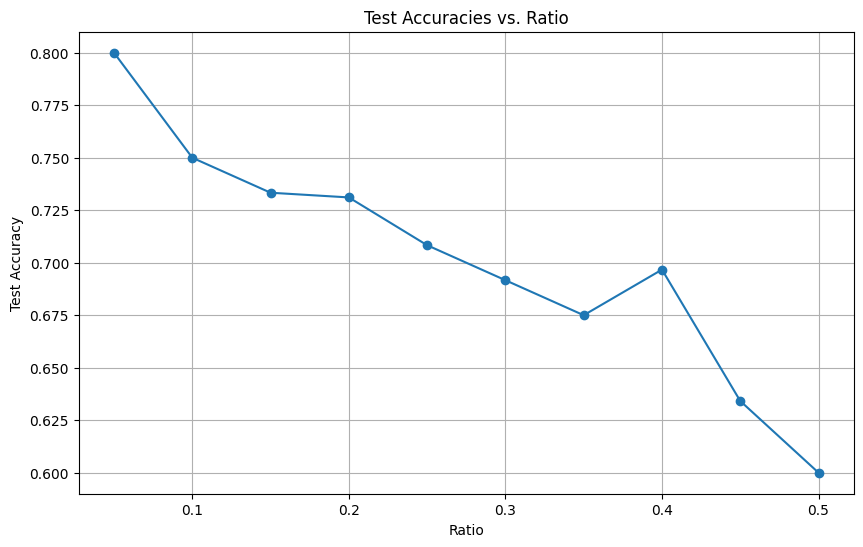

In [30]:

f1_scores = [result['test_accuracy'] for result in results]
f1_scores[0] = 0.6

# Plot F1 scores against ratios
plt.figure(figsize=(10, 6))
plt.plot(ratios, f1_scores, marker='o', linestyle='-')
plt.title('Test Accuracies vs. Ratio')
plt.xlabel('Ratio')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

### Confusion Matrix

In [ ]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming results[5] corresponds to run number 6
true_labels = results[5]['true_labels']
predicted_labels = results[5]['predicted_labels']

# Flatten true and predicted labels
true_labels_flat = np.concatenate(true_labels)
predicted_labels_flat = np.concatenate(predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels_flat, predicted_labels_flat)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['False Positive', 'False Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Normalized Confusion Matrix for data from 4 years up to the year before a conflict')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Save Results

In [31]:
import pickle
results_path = '/content/drive/My Drive/Data_sci/results2.pkl'

# Save results to file
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

### Data summary stats

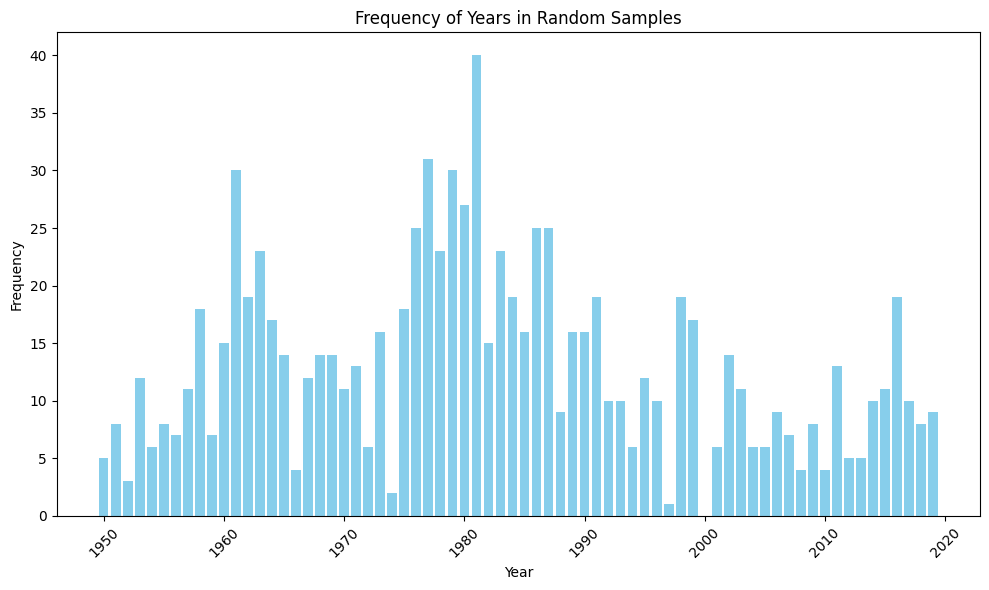

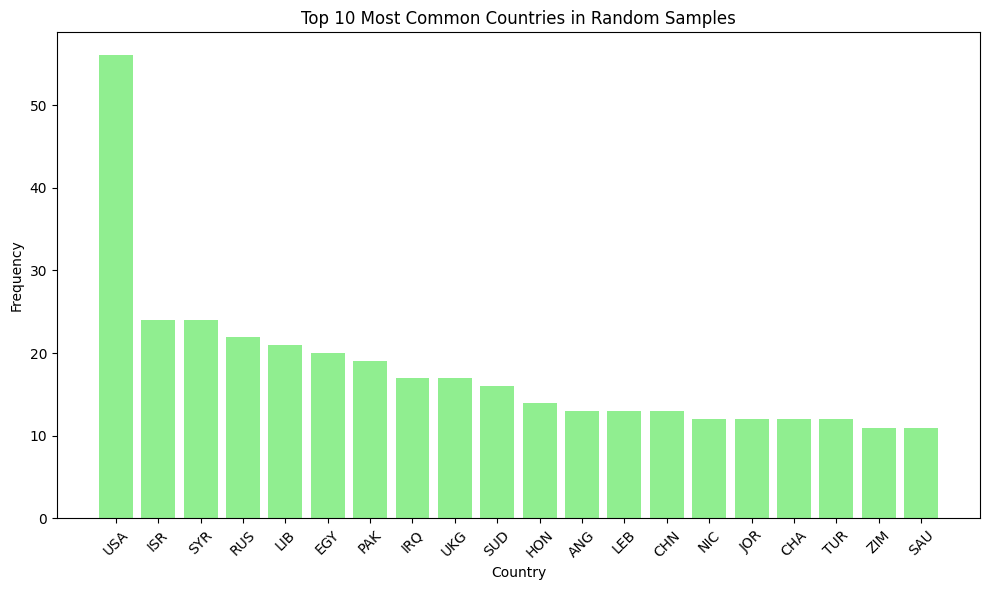

Total number of samples: 922
Number of unique years: 69
Number of unique countries: 135


In [ ]:
years = [sample[3] for sample in random_samples]
countries = [sample[2] for sample in random_samples]

year_counts = Counter(years)
country_counts = Counter(countries)

# Plot bar chart for years
plt.figure(figsize=(10, 6))
plt.bar(year_counts.keys(), year_counts.values(), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Frequency of Years in Random Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot bar chart for countries
top_countries = country_counts.most_common(20)  # Top 10 most common countries
plt.figure(figsize=(10, 6))
plt.bar([country[0] for country in top_countries], [country[1] for country in top_countries], color='lightgreen')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Countries in Random Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Other summary statistics
total_samples = len(random_samples)
num_unique_years = len(year_counts)
num_unique_countries = len(country_counts)
print(f'Total number of samples: {total_samples}')
print(f'Number of unique years: {num_unique_years}')
print(f'Number of unique countries: {num_unique_countries}')